# Rossmann销售预测
Kaggle项目地址：https://www.kaggle.com/c/rossmann-store-sales

**环境要求：**
* Python 3.x
* Keras

## 1.数据分析

### 导入数据、

In [1]:
import visulization as vs
%matplotlib inline

data = vs.load_data()

print(data.head(3))

   Store       Date  Sales  Customers  Open  Promo StateHoliday  SchoolHoliday
0      1 2015-07-31   5263        555     1      1            0              1
1      2 2015-07-31   6064        625     1      1            0              1
2      3 2015-07-31   8314        821     1      1            0              1


### 可视化分析
#### 年、月销售趋势

array([411, 406, 842, 560, 953])

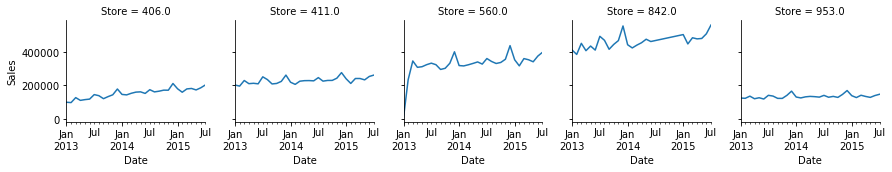

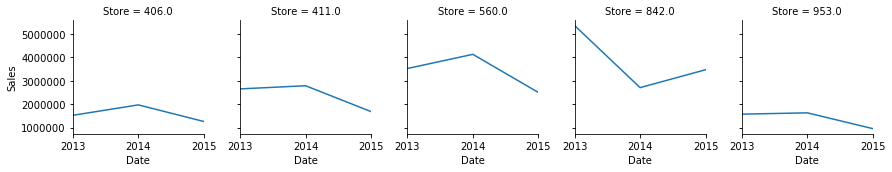

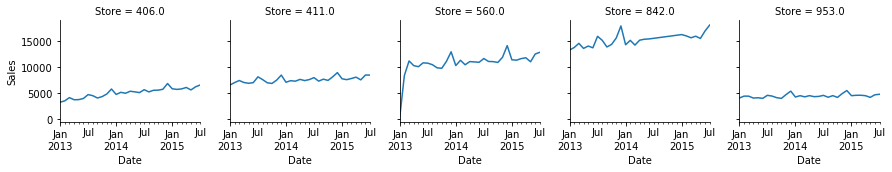

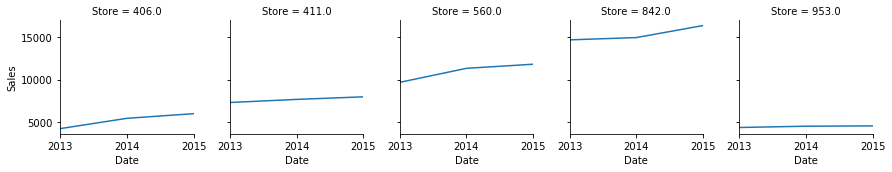

In [2]:
# Take 5 random stores to view the sales by dates, monthly & yearly view
# Monthly sum view
stores = vs.viewRandomStoreData(data,"M",'sum',size = 5)
# Yearly sum view
vs.viewStoreData(data,stores,"A",'sum')
# Monthly mean value view
vs.viewStoreData(data,stores, "M",'mean')
# Yearly mean value view
vs.viewStoreData(data,stores, "A",'mean')

#### 其他特征值趋势

## 2.基准模型

## 3.Enbedding神经网络的实现
### 数据预处理

In [1]:
import prepare_data as raw_data

# Load data from csv files, as dict format
raw_data.read_data_as_dicts()

Titles:
['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']
3 samples:
[{'Store': '1115', 'DayOfWeek': '2', 'Date': '2013-01-01', 'Sales': '0', 'Customers': '0', 'Open': '0', 'Promo': '0', 'StateHoliday': 'a', 'SchoolHoliday': '1'}, {'Store': '1114', 'DayOfWeek': '2', 'Date': '2013-01-01', 'Sales': '0', 'Customers': '0', 'Open': '0', 'Promo': '0', 'StateHoliday': 'a', 'SchoolHoliday': '1'}, {'Store': '1113', 'DayOfWeek': '2', 'Date': '2013-01-01', 'Sales': '0', 'Customers': '0', 'Open': '0', 'Promo': '0', 'StateHoliday': 'a', 'SchoolHoliday': '1'}]

Titles:
['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
Titles:
['Store', 'State']
2 samples:
[{'Store': '1', 'StoreType': 'c', 'Assortment': 'a', 'CompetitionDistance': '1270', 'CompetitionOpenSinceMonth': '9', 'CompetitionOpenSinceYear': '2008', 'Promo2': '

In [2]:
# Prepare data for processing, including reformat, standanlize, encoding
(X,y) = raw_data.prepare_data_for_process()
print("prepare data complete")
#print(type(X))

Prepare data from processning
Number of train datapoints:  844338
46 41551
[  0 109   1   0   0   0   0   7] 5961
prepare data complete


### 创建并训练模型

In [3]:
import numpy
from network import Enbedding_Network as ENW

train_ratio = 0.9

num_records = len(X)
train_size = int(train_ratio * num_records)

X_train = X[:train_size]
X_val = X[train_size:]
y_train = y[:train_size]
y_val = y[train_size:]

def sample(X, y, n):
    '''random samples'''
    num_row = X.shape[0]
    indices = numpy.random.randint(num_row, size=n)
    return X[indices, :], y[indices]

models = []
sample_size = 10000
fit_epoch = 3

print("Build embedding network with Keras ...")
for i in range(3):
    X_train, y_train = sample(X_train, y_train, sample_size)  # take a random sample for training
    print("Number of samples used for training: " + str(y_train.shape[0]))
    model = ENW(X_train, y_train, X_val, y_val, fit_epoch)
    model.fit_model(X_train, y_train, X_val, y_val)
    models.append(model)

# Save modle    
#with open('models.pickle', 'wb') as f:
#    pickle.dump(models, f)

# Evaluate model 
def evaluate_models(models, X, y):
    assert(min(y) > 0)
    predict_sales = numpy.array([model.predict(X) for model in models])
    mean_sales = predict_sales.mean(axis=0)
    relative_err = numpy.absolute((y - mean_sales) / y)
    result = numpy.sum(relative_err) / len(y)
    return result

print("Evaluate combined models...")
print("Training error...")
r_train = evaluate_models(models, X_train, y_train)
print(r_train)

print("Validation error...")
r_val = evaluate_models(models, X_val, y_val)
print(r_val)

Using TensorFlow backend.


Build embedding network with Keras ...
Number of samples used for training: 10000
Train on 10000 samples, validate on 84434 samples
Epoch 1/3
10000/10000 [==============================] - 6s - loss: 0.0588 - val_loss: 0.0214
Epoch 2/3
10000/10000 [==============================] - 7s - loss: 0.0171 - val_loss: 0.0155
Epoch 3/3
10000/10000 [==============================] - 6s - loss: 0.0140 - val_loss: 0.0144
Result for validation dataset:  0.160888923219
Number of samples used for training: 10000
Train on 10000 samples, validate on 84434 samples
Epoch 1/3
10000/10000 [==============================] - 6s - loss: 0.0530 - val_loss: 0.0206
Epoch 2/3
10000/10000 [==============================] - 6s - loss: 0.0159 - val_loss: 0.0164
Epoch 3/3
10000/10000 [==============================] - 6s - loss: 0.0131 - val_loss: 0.0154
Result for validation dataset:  0.175914032716
Number of samples used for training: 10000
Train on 10000 samples, validate on 84434 samples
Epoch 1/3
10000/10000 [=

# Temp

In [ ]:
import numpy as np
data = np.random.random(size=(6, 4))
print((data))

labels = np.random.randint(10, size=(6, 1))
print(labels)

print(data[0])
data_x = []
data_x.append(data[0])
data_x.append(data[2])
print((data_x))
#data_x = np.array(data_x)
print(np.array(data_x))

sample = np.random.randint(4, size=2)

sample_x = data[sample,:]

print(sample_x)


X_list = []

store_index = sample_x[..., [1]]
X_list.append(store_index)

day_of_week = sample_x[..., [2]]
X_list.append(day_of_week)

print(X_list)